In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os,sys
#sys.path.append('/work/qdiff/mo_utils')
sys.executable


'/home/nadavg/anaconda3/envs/qdiff/bin/python'

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [6]:
#from mo_utils.utils.torch_utils import torch_to_pt,create_torch_script
import netron
from pathlib import Path

In [7]:
from qdiff import (
    QuantModel, QuantModule, BaseQuantBlock,
    block_reconstruction, layer_reconstruction,
)
from qdiff.utils import resume_cali_model, get_train_samples


In [8]:
from scripts.gen_image import gen_image_from_prompt

In [9]:
import torch
from omegaconf import OmegaConf
from txt2img import load_model_from_config
from pytorch_lightning import seed_everything
from ldm.models.diffusion.plms import PLMSSampler
from qdiff.quant_layer import UniformAffineQuantizer
from qdiff.adaptive_rounding import AdaRoundQuantizer
import numpy as np
import matplotlib.pyplot as plt
from mo_utils.utils.plot_aux import plot_hist, myim


/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/nadavg/anaconda3/envs/qdiff/lib/python3.8/site-packages/transformers/modeling_utils.py:371: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

libtmux not installed ??


In [128]:
#cali_ckpt = '/fastdata/users/nadavg/sd/qdiff/sd_w4a8_ckpt.pth'
cali_ckpt,nbit,symmetric   = '/fastdata/users/nadavg/sd/qdiff/sd_w8a8_ckpt.pth' ,8,False
#w8bit_nosym,nbit,symmetric = '/fastdata/users/nadavg/sd/qdiff/output_quantization/2025-01-22-16-39-34/wc_ckpt.pth',8,False
#w8bit_sym = "/fastdata/users/nadavg/sd/qdiff/output_quantization/2025-01-22-16-40-17/wc_ckpt.pth"
#w8bit_sym,nbit,symmetric   = '/home/nadavg/q-diffusion/output_quantization2/2025-01-24-00-49-55/wc_ckpt.pth',8,True

In [129]:
seed = 42
seed_everything(seed)

Global seed set to 42


42

In [130]:
config = OmegaConf.load(f'{Path.home()}/q-diffusion/configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, "/fastdata/users/nadavg/sd/qdiff/sd-v1-4.ckpt")
device = torch.device("cuda")
model = model.to(device)
sampler = PLMSSampler(model)

LatentDiffusion: Running in eps-prediction mode


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.weight', 'vision_model.encoder.layers.11.layer_norm1.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.layer_norm2.bias', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.20.sel

In [131]:
unet = model.model.diffusion_model

In [132]:
setattr(sampler.model.model.diffusion_model, "split", True)

In [133]:
#wq_params = {'n_bits': 4, 'channel_wise': True, 'scale_method': 'mse'}
wq_params = {'n_bits': nbit, 'channel_wise': True, 'scale_method': 'mse','symmetric':symmetric}
#wq_params = {'n_bits': 8, 'channel_wise': True, 'scale_method': 'mse','symmetric':False}

aq_params = {'n_bits': 8, 'channel_wise': False, 'scale_method': 'mse', 'leaf_param':  True}
wq_params['scale_method'] = 'max'
aq_params['scale_method'] = 'max'

In [135]:
symmetric,nbit

(False, 8)

In [136]:
qnn = QuantModel(
    model=sampler.model.model.diffusion_model, weight_quant_params=wq_params, act_quant_params=aq_params,
                act_quant_mode="qdiff", sm_abit=16)

In [137]:
qnn.cuda()
qnn.eval()
qnn.set_grad_ckpt(False)

In [138]:
cali_data = (torch.randn(1, 4, 64, 64), torch.randint(0, 1000, (1,)), torch.randn(1, 77, 768))
resume_cali_model(qnn, cali_ckpt, cali_data, True, "qdiff", cond=True)
#resume_cali_model(qnn, w8bit_sym, cali_data, False, "qdiff", cond=True)
#resume_cali_model(qnn, w8bit_nosym, cali_data, False, "qdiff", cond=True)

Loading quantized model checkpoint
Initializing weight quantization parameters
Initializing act quantization parameters
Loading quantized model checkpoint again


In [123]:
prompt = "a puppy wearing a hat"

In [49]:
grid = gen_image_from_prompt(model,sampler,prompt)

Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 50 timesteps





















































Sampling:  50%|█████     | 1/2 [00:16<00:16, 16.46s/it]

Data shape for PLMS sampling is (5, 4, 64, 64)
Running PLMS Sampling with 50 timesteps





















































Sampling: 100%|██████████| 2/2 [00:32<00:00, 16.26s/it]


None: Keep using EMA weights


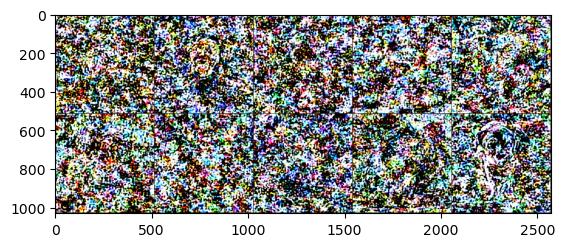

In [51]:
plt.imshow(grid)

In [139]:
M=[]
for name, module in qnn.named_modules():
    if isinstance(module, QuantModule):
        M.append((name,module))
    #print(f"Name: {name}, Module: {module}")

In [140]:
len(M)

282

In [126]:
M[20][1].weight_quantizer.n_levels,M[20][1].weight_quantizer.sym

(127, True)

In [141]:
n= 50#,200

In [207]:
M[n][0],M[n][1].weight_quantizer.n_levels,M[n][1].weight_quantizer.sym

('model.input_blocks.5.0.in_layers.2', 256, False)

In [211]:
M[n][1].weight_quantizer.round_mode,M[n][1].weight_quantizer.soft_targets

('learned_hard_sigmoid', False)

In [143]:
np.unique(M[n][1].weight_quantizer.zero_point.cpu().detach())#, M[n].weight_quantizer.delta

array([ 64.,  88.,  90.,  91.,  92.,  94.,  95.,  96.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
       156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.,
       168., 170., 171., 172., 173., 176., 177., 178., 180.],
      dtype=float32)

In [144]:
W  = M[n][1].weight.cpu().detach().numpy()

In [145]:
W.shape

(640, 640, 3, 3)

In [146]:
stats = W.mean(axis=(1,2,3)),W.max(axis=(1,2,3)),W.min(axis=(1,2,3))

In [147]:
ratio = np.abs((stats[1] + stats[2])/2 ) / np.maximum(np.abs(stats[1]),np.abs(stats[2]))

In [148]:
stats[1].shape

(640,)

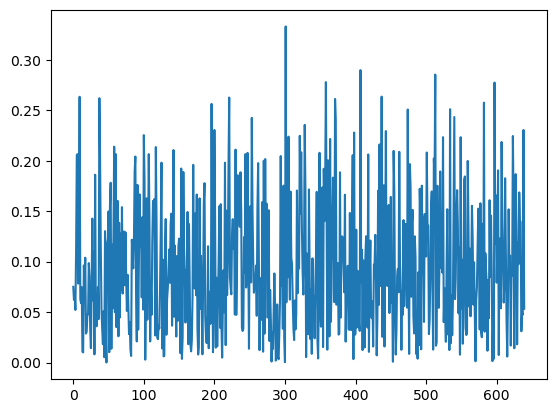

In [149]:
plt.plot(ratio)

In [150]:
Wq = M[n][1].weight_quantizer(M[n][1].weight).cpu().detach().numpy()

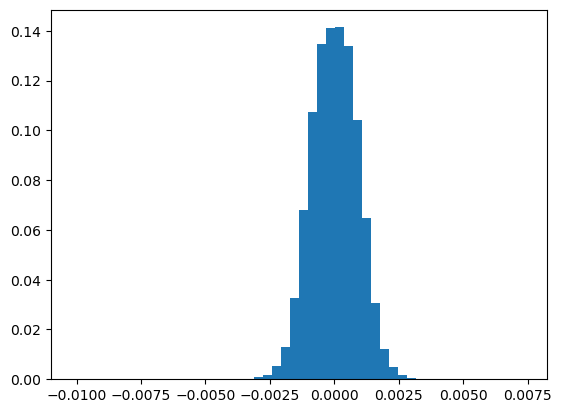

In [155]:
h,b=plot_hist((W-Wq))

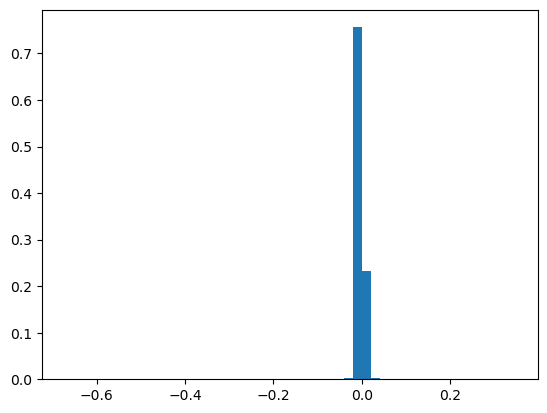

In [ ]:
h,b=plot_hist((W-Wq))

In [184]:
ckpt1 = torch.load(cali_ckpt, map_location='cpu')
cali_ckpt

/tmp/ipykernel_3105378/3159849480.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt1 = torch.load(cali_ckpt, map_location='cpu')


'/fastdata/users/nadavg/sd/qdiff/sd_w8a8_ckpt.pth'

In [188]:
ckpt2 = torch.load(w8bit_sym, map_location='cpu')
w8bit_sym

/tmp/ipykernel_3105378/1739548272.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt2 = torch.load(w8bit_sym, map_location='cpu')


'/home/nadavg/q-diffusion/output_quantization2/2025-01-24-00-49-55/wc_ckpt.pth'

In [189]:
kk = [k for k in ckpt2.keys() if 'model.input_blocks.5.0.in_layers.2' in k]
kk

['model.input_blocks.5.0.in_layers.2.weight',
 'model.input_blocks.5.0.in_layers.2.bias',
 'model.input_blocks.5.0.in_layers.2.weight_quantizer.alpha',
 'model.input_blocks.5.0.in_layers.2.weight_quantizer.zero_point',
 'model.input_blocks.5.0.in_layers.2.weight_quantizer.delta']

In [190]:
(ckpt1[kk[0]]-ckpt2[kk[0]]).abs().sum(),(ckpt1[kk[1]]-ckpt2[kk[1]]).abs().sum(),(ckpt1[kk[4]]-ckpt2[kk[4]]).abs().max()

(tensor(0.), tensor(0.), tensor(0.0036))

In [198]:
(ckpt1[kk[4]]-ckpt2[kk[4]]).abs().cpu().detach().numpy().shape

(640, 1, 1, 1)

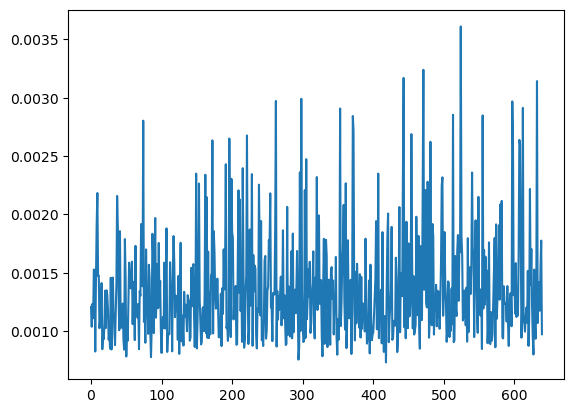

In [199]:
plt.plot((ckpt1[kk[4]]-ckpt2[kk[4]]).abs().cpu().detach().numpy().squeeze())    

In [212]:
(ckpt1[kk[2]].cpu().detach().numpy()<0).sum(),(ckpt2[kk[2]].cpu().detach().numpy()<0).sum()

(1843461, 1844250)

In [216]:
(ckpt1[kk[2]] >= 0).float() - (ckpt2[kk[2]] >= 0).float()

tensor([[[[-1., -1.,  0.],
          [ 0.,  0., -1.],
          [ 0., -1.,  0.]],

         [[-1.,  0.,  0.],
          [ 1.,  1., -1.],
          [ 0.,  1.,  0.]],

         [[-1.,  0., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],

         ...,

         [[-1.,  1.,  1.],
          [ 1.,  0.,  0.],
          [ 1.,  0.,  0.]],

         [[ 1.,  1.,  0.],
          [-1., -1.,  0.],
          [ 0.,  1.,  1.]],

         [[ 0.,  0.,  1.],
          [ 0.,  0.,  0.],
          [ 0.,  1.,  0.]]],


        [[[-1.,  0., -1.],
          [ 0.,  0., -1.],
          [ 0., -1., -1.]],

         [[ 0., -1., -1.],
          [-1.,  0.,  0.],
          [-1., -1., -1.]],

         [[ 0.,  0., -1.],
          [ 0., -1.,  0.],
          [-1., -1.,  0.]],

         ...,

         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0., -1.,  1.]],

         [[ 0., -1.,  0.],
          [-1.,  0.,  0.],
          [ 0., -1.,  1.]],

         [[ 1.,  0.,  1.],
          [ 0.,  0.,  0.],
 

In [213]:
da = (ckpt1[kk[2]].cpu().detach().numpy()-ckpt2[kk[2]].cpu().detach().numpy())

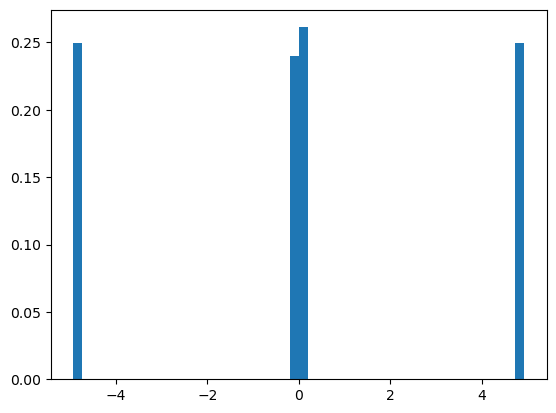

In [205]:
_=plot_hist(da)

In [206]:
da.max(),da.min()

(4.9281006, -4.9289265)

In [200]:
(ckpt1[kk[2]]-ckpt2[kk[2]]).abs().max()

tensor(4.9289)

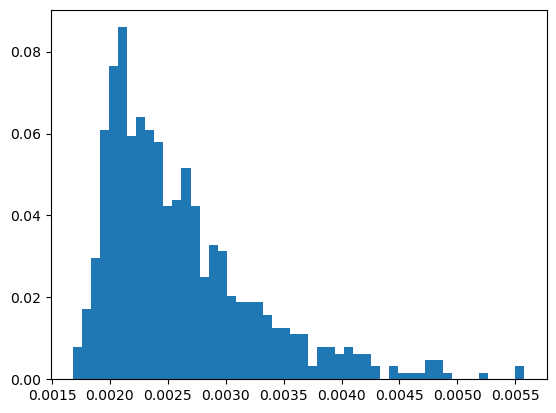

In [172]:
_=plot_hist(ckpt1[kk[4]])

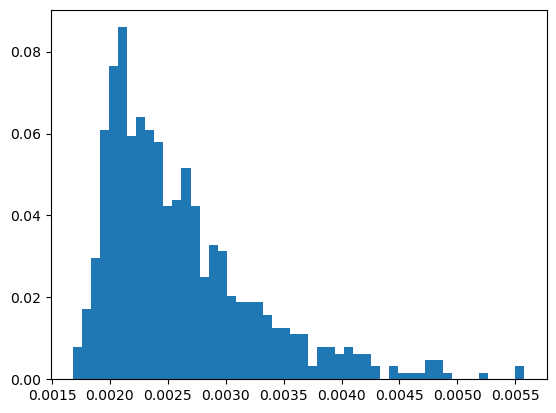

In [173]:
_=plot_hist(ckpt2[kk[4]])

In [ ]:
ckpt1[]

In [157]:
w8bit_nosym

'/fastdata/users/nadavg/sd/qdiff/output_quantization/2025-01-22-16-39-34/wc_ckpt.pth'

In [153]:
len(np.unique(Wq[10]))

167

In [30]:
#w8bit_sym
ckpt = torch.load(w8bit_sym, map_location='cpu')

/tmp/ipykernel_2369004/2317048779.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w8bit_sym, map_location='cpu')


In [33]:
zps= [k for k in ckpt.keys() if 'zero_point' in k]

In [34]:
ckpt[zps[0]]

tensor([[126.],
        [135.],
        [116.],
        ...,
        [135.],
        [121.],
        [129.]])

In [14]:
#sampler.model.model.diffusion_model = qnn

In [16]:
type(qnn.model)

ldm.modules.diffusionmodules.openaimodel.UNetModel

In [17]:
unet = model.model.diffusion_model

In [18]:
qunet = qnn.model

In [19]:
for m in qunet.modules():
    if isinstance(m, QuantModule):
        #print(m)
        #print(m.weight_quant_params)
        if not isinstance(m.act_quantizer,UniformAffineQuantizer):
            print(m.act_quantizer)
            print(m.act_quant_params)
        
        #print(m.act_quant_mode)
        #print(m.sm_abit)
        #print(m.leaf_param)
        #print(m.channel_wise)
        #print(m.scale_method)
        #print('---')

In [20]:
len(qunet.input_blocks),len(qunet.middle_block),len(qunet.output_blocks)

(12, 3, 12)

In [21]:
lt = lambda l : str(type(l)).split('.')[-1].split('\'')[0]

In [22]:
in_b =[]
for i,inb_i in enumerate(qunet.input_blocks):
    in_b.append([])
    for l in inb_i:
        in_b[i].append(lt(l))
in_b
        

[['QuantModule'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['QuantResBlock'],
 ['QuantResBlock']]

In [23]:
in_b=[]
for l in qunet.middle_block:
    in_b.append(lt(l))
in_b

['QuantResBlock', 'SpatialTransformer', 'QuantResBlock']

In [24]:
in_b =[]
for i,inb_i in enumerate(qunet.output_blocks):
    in_b.append([])
    for l in inb_i:
        in_b[i].append(lt(l))
in_b
        

[['QuantResBlock'],
 ['QuantResBlock'],
 ['QuantResBlock', 'Upsample'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer', 'Upsample'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer', 'Upsample'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer'],
 ['QuantResBlock', 'SpatialTransformer']]

In [25]:
c2d = qunet.input_blocks[0][0]
rb = qunet.input_blocks[1][0]
us = qunet.output_blocks[2][1]
ds = qunet.input_blocks[3][0]
st = qunet.input_blocks[1][1]
rb_u = qunet.output_blocks[0][0]
type(c2d),type(rb),type(ds),type(us),type(st),type(rb_u)

(qdiff.quant_layer.QuantModule,
 qdiff.quant_block.QuantResBlock,
 ldm.modules.diffusionmodules.openaimodel.Downsample,
 ldm.modules.diffusionmodules.openaimodel.Upsample,
 ldm.modules.attention.SpatialTransformer,
 qdiff.quant_block.QuantResBlock)

In [25]:
#qunet.output_blocks[0][0].in_layers

In [26]:
c2d

QuantModule(
  4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
  (weight_quantizer): AdaRoundQuantizer(bit=8, symmetric=False, round_mode=learned_hard_sigmoid)
  (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
  (activation_function): StraightThrough()
)

In [29]:
c2d.weight_quantizer.zero_point

tensor([[[[134.]]],


        [[[173.]]],


        [[[ 82.]]],


        [[[127.]]],


        [[[111.]]],


        [[[149.]]],


        [[[108.]]],


        [[[144.]]],


        [[[111.]]],


        [[[136.]]],


        [[[160.]]],


        [[[131.]]],


        [[[118.]]],


        [[[142.]]],


        [[[136.]]],


        [[[ 87.]]],


        [[[ 96.]]],


        [[[130.]]],


        [[[ 82.]]],


        [[[106.]]],


        [[[167.]]],


        [[[131.]]],


        [[[109.]]],


        [[[164.]]],


        [[[136.]]],


        [[[ 96.]]],


        [[[169.]]],


        [[[117.]]],


        [[[158.]]],


        [[[124.]]],


        [[[113.]]],


        [[[121.]]],


        [[[105.]]],


        [[[119.]]],


        [[[ 94.]]],


        [[[125.]]],


        [[[122.]]],


        [[[ 90.]]],


        [[[134.]]],


        [[[121.]]],


        [[[127.]]],


        [[[105.]]],


        [[[127.]]],


        [[[132.]]],


        [[[154.]]],


        [[

In [30]:
rb.updown

False

In [28]:
rb.in_layers

Sequential(
  (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
  (1): SiLU()
  (2): QuantModule(
    320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (weight_quantizer): AdaRoundQuantizer(bit=8, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
)

In [26]:
rb.in_layers[2].act_quantizer#.activation_function

UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)

In [23]:
rb.emb_layers

Sequential(
  (0): SiLU()
  (1): QuantModule(
    in_features=1280, out_features=320, bias=True
    (weight_quantizer): AdaRoundQuantizer(bit=8, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
)

In [29]:
rb.out_layers

Sequential(
  (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
  (1): SiLU()
  (2): Dropout(p=0, inplace=False)
  (3): QuantModule(
    320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (weight_quantizer): AdaRoundQuantizer(bit=8, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
)

In [35]:
ds

Downsample(
  (op): QuantModule(
    320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
    (weight_quantizer): AdaRoundQuantizer(bit=8, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
)

In [32]:
aq = rb.in_layers[2].act_quantizer

In [37]:
aq.sym, aq.delta, aq.zero_point, aq.n_bits,aq.channel_wise,aq.scale_method

(False,
 Parameter containing:
 tensor(0.0327, device='cuda:0', requires_grad=True),
 8,
 8,
 False,
 'max')

In [36]:
type(st)

ldm.modules.attention.SpatialTransformer

In [37]:
st.norm

GroupNorm(32, 320, eps=1e-06, affine=True)

In [34]:
st.proj_in

QuantModule(
  320, 320, kernel_size=(1, 1), stride=(1, 1)
  (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
  (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
  (activation_function): StraightThrough()
)

In [36]:
st.transformer_blocks[0].attn1
#.qk_matmul#.qk_matmul

CrossAttention(
  (to_q): QuantModule(
    in_features=320, out_features=320, bias=False
    (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
  (to_k): QuantModule(
    in_features=320, out_features=320, bias=False
    (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
    (activation_function): StraightThrough()
  )
  (to_v): QuantModule(
    in_features=320, out_features=320, bias=False
    (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
    (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
 

In [31]:
rb_u.skip_connection#.updown

QuantModule(
  2560, 1280, kernel_size=(1, 1), stride=(1, 1)
  (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
  (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
  (activation_function): StraightThrough()
  (weight_quantizer_0): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
  (act_quantizer_0): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
)

x.shape = torch.Size([3, 4, 64, 64])

t.shape = torch.Size([3]) 

c.shape = torch.Size([3, 77, 768])

In [47]:
qnn.model

UNetModel(
  (time_embed): Sequential(
    (0): QuantModule(
      in_features=320, out_features=1280, bias=True
      (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
      (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
      (activation_function): StraightThrough()
    )
    (1): SiLU()
    (2): QuantModule(
      in_features=1280, out_features=1280, bias=True
      (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode=learned_hard_sigmoid)
      (act_quantizer): UniformAffineQuantizer(bit=8, scale_method=max, symmetric=False, channel_wise=False, leaf_param=True)
      (activation_function): StraightThrough()
    )
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): QuantModule(
        4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (weight_quantizer): AdaRoundQuantizer(bit=4, symmetric=False, round_mode

In [66]:
_=qnn.cuda()
_=qnn.model.cuda()

In [67]:
input_shapes = [[3, 4, 64, 64],[3],[3,77,768]]

In [68]:
import torch
device='cuda'#'cpu'
input_data = [torch.randn(input_shape).to(device) for input_shape in input_shapes]
[input_data[0].shape,input_data[1].shape,input_data[2].shape]
#input_data


[torch.Size([3, 4, 64, 64]), torch.Size([3]), torch.Size([3, 77, 768])]

In [69]:
from ldm.modules.diffusionmodules.openaimodel import ResBlock
from qdiff.quant_block import QuantResBlock

In [70]:
qnn.model.model_channels

320

In [72]:
from ldm.modules.diffusionmodules.util import timestep_embedding
t_emb = timestep_embedding(input_data[1],qnn.model.model_channels, repeat_only=False)
emb = qnn.model.time_embed(t_emb)

In [74]:
in_rs1 = c2d(input_data[0])

In [ ]:
rb.use_checkpoint = False

True

In [77]:
rb.eval()
rb.requires_grad_(False)
rb.use_checkpoint = False
traced_resblock = torch.jit.trace(rb,(in_rs1,emb),_store_inputs=True)
traced_resblock.save('traced_Qresblock.pt')

/work/qdiff/q-diffusion-org/qdiff/quant_block.py:88: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[2] == x.shape[3]
/opt/conda/envs/qdiff_reorg/lib/python3.8/site-packages/torch/jit/_trace.py:168: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not 

In [7]:
type(model.model.diffusion_model)

ldm.modules.diffusionmodules.openaimodel.UNetModel

In [8]:
unet = model.model.diffusion_model

In [12]:
len(unet.input_blocks),len(unet.middle_block),len(unet.output_blocks)

(12, 3, 12)

In [45]:
lt = lambda l : str(type(l)).split('.')[-1].split('\'')[0]

In [48]:
a =[] 
a.append([])

In [50]:
a[0]

[]

In [52]:
in_b =[]
for i,inb_i in enumerate(unet.input_blocks):
    in_b.append([])
    for l in inb_i:
        in_b[i].append(lt(l))
in_b
        

[['Conv2d'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['Downsample'],
 ['ResBlock'],
 ['ResBlock']]

In [56]:
in_b=[]
for l in unet.middle_block:
    in_b.append(lt(l))
in_b

['ResBlock', 'SpatialTransformer', 'ResBlock']

In [54]:
in_b =[]
for i,inb_i in enumerate(unet.output_blocks):
    in_b.append([])
    for l in inb_i:
        in_b[i].append(lt(l))
in_b
        

[['ResBlock'],
 ['ResBlock'],
 ['ResBlock', 'Upsample'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer', 'Upsample'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer', 'Upsample'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer'],
 ['ResBlock', 'SpatialTransformer']]

In [68]:
type(unet.output_blocks[1][0])

ldm.modules.diffusionmodules.openaimodel.ResBlock

In [76]:
unet.output_blocks[5][0].updown

False

In [152]:
c2d = unet.input_blocks[0][0]
rb = unet.input_blocks[1][0]
us = unet.output_blocks[2][1]
ds = unet.input_blocks[3][0]
st = unet.input_blocks[1][1]
type(c2d),type(rb),type(ds),type(us),type(st)

(torch.nn.modules.conv.Conv2d,
 ldm.modules.diffusionmodules.openaimodel.ResBlock,
 ldm.modules.diffusionmodules.openaimodel.Downsample,
 ldm.modules.diffusionmodules.openaimodel.Upsample,
 ldm.modules.attention.SpatialTransformer)

In [153]:
ds.use_conv,us.use_conv

(True, True)

In [154]:
rb.in_layers

Sequential(
  (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
  (1): SiLU()
  (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [155]:
rb.emb_layers

Sequential(
  (0): SiLU()
  (1): Linear(in_features=1280, out_features=320, bias=True)
)

In [156]:
rb.out_layers

Sequential(
  (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
  (1): SiLU()
  (2): Dropout(p=0, inplace=False)
  (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [84]:
rb.skip_connection

Identity()

In [162]:
st.norm,st.proj_in,st.proj_out

(GroupNorm(32, 320, eps=1e-06, affine=True),
 Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1)))

In [161]:
len(st.transformer_blocks)

1

In [165]:
st.transformer_blocks[0].attn1, st.transformer_blocks[0].attn2

(CrossAttention(
   (to_q): Linear(in_features=320, out_features=320, bias=False)
   (to_k): Linear(in_features=320, out_features=320, bias=False)
   (to_v): Linear(in_features=320, out_features=320, bias=False)
   (qk_matmul): CrossQKMatMul()
   (smv_matmul): CrossSMVMatMul()
   (to_out): Sequential(
     (0): Linear(in_features=320, out_features=320, bias=True)
     (1): Dropout(p=0.0, inplace=False)
   )
 ),
 CrossAttention(
   (to_q): Linear(in_features=320, out_features=320, bias=False)
   (to_k): Linear(in_features=768, out_features=320, bias=False)
   (to_v): Linear(in_features=768, out_features=320, bias=False)
   (qk_matmul): CrossQKMatMul()
   (smv_matmul): CrossSMVMatMul()
   (to_out): Sequential(
     (0): Linear(in_features=320, out_features=320, bias=True)
     (1): Dropout(p=0.0, inplace=False)
   )
 ))

In [41]:
inb_i = unet.input_blocks[0]
#len(inb_i)
for l in inb_i:
    print(type(l))

<class 'torch.nn.modules.conv.Conv2d'>


In [46]:
lt(l)

'Conv2d'

In [ ]:
rb

In [51]:
model.model.diffusion_model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 

In [85]:
import torch
device='cpu'
input_data = [torch.randn(input_shape).to(device) for input_shape in input_shapes]
[input_data[0].shape,input_data[1].shape,input_data[2].shape]
#input_data


[torch.Size([3, 4, 64, 64]), torch.Size([3]), torch.Size([3, 77, 768])]

In [86]:
input_data = tuple(input_data)

In [88]:
input_data[2].device

device(type='cpu')

In [87]:
_=model.cpu()

In [55]:
input_unet = {'x':input_data[0],'timesteps':input_data[1],'context':input_data[2]}

In [105]:
from torchviz import make_dot

In [92]:
from ldm.modules.diffusionmodules.util import timestep_embedding
t_emb = timestep_embedding(input_data[1], model.model.diffusion_model.model_channels, repeat_only=False)
emb = model.model.diffusion_model.time_embed(t_emb)

In [93]:
emb.shape

torch.Size([3, 1280])

In [101]:
in_rs1 = c2d(input_data[0])

In [110]:
rs1_out= rb._forward(in_rs1,emb)

In [111]:
#make_dot(rs1_out, params=dict(list(rb.named_parameters()))).render("rb1", format="svg")
make_dot(rs1_out, params=None).render("rb1", format="svg")



'rb1.svg'

In [137]:
_=rb.eval()

In [141]:
traced_resblock = torch.jit.script(rb)#._forward,example_inputs=[rb,in_rs1,emb])
#traced_resblock.save('script_resblock.pt')

RuntimeError: Can't redefine method: forward on class: __torch__.ldm.modules.diffusionmodules.util.___torch_mangle_186.GroupNorm32 (of Python compilation unit at: 0x5594424b26a0)

In [142]:
rb.eval()
rb.requires_grad_(False)
traced_resblock = torch.jit.trace_module(rb,{'_forward':(in_rs1,emb)},_store_inputs=True)
traced_resblock.save('traced_resblock.pt')

/opt/conda/envs/qdiff_reorg/lib/python3.8/site-packages/torch/jit/_trace.py:168: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:


In [ ]:
with torch.no_grad():
    torch.onnx.export(rb._forward,(in_rs1,emb),'resblock.onnx',
                   input_names=['x','timestep_embedding'], output_names=['res_block_out'])

AttributeError: 'function' object has no attribute 'modules'

In [90]:
model.model.diffusion_model.model_channels

320

In [88]:
yhat = model.model.diffusion_model(*input_data)

In [96]:
make_dot(yhat, params=dict(list(model.model.diffusion_model.named_parameters()))).render("rnn_torchviz", format="png")


'rnn_torchviz.png'

In [89]:
model.model.diffusion_model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 

In [83]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] #

In [91]:
graph = hl.build_graph(model.model.diffusion_model, input_data, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

IndexError: Argument passed to at() was not in the map.

In [56]:
#outout_unet= model.model.diffusion_model(**input_unet)
outout_unet= model.model.diffusion_model(*input_data)

outout_unet.shape

torch.Size([3, 4, 64, 64])

In [79]:
input_names = ['x','timesteps','context']
output_names = ['h']
torch.onnx.export(model.model.diffusion_model,(input_data[0],input_data[1],input_data[2]),
                   'UNetModel.onnx',
                   input_names=input_names, output_names=output_names)

RuntimeError: _Map_base::at

In [90]:
torch.onnx._optimize_trace

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'

In [75]:
traced_model = torch.jit.trace(model.model.diffusion_model, (input_data[0],input_data[1],input_data[2]))
#traced_model = torch.jit.trace(model.model.diffusion_model, input_data)

#traced_model = torch.jit.trace(model.model.diffusion_model, **input_unet)



RuntimeError: _Map_base::at

In [14]:
create_torch_script(model.model.diffusion_model,input_shapes)

RuntimeError: _Map_base::at